<img src="https://www.ncei.noaa.gov/themes/custom/ncei/logo.svg" width="800">

## Data from NOAA's National Data Buoy Center (NDBC)

NOAA (National Oceanic and Atmospheric Administration) is the agency of the United States responsible for the collection, storage, and dissemination of oceanograpphic and atmospheric data.

The National Data Buoy Center (NDBC) is a network of buoy stations that monitor the environmental conditions and wave height of the ocean along the coasts of the United States.

Sources:
- https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:NDBC-CMANWx
- https://www.ndbc.noaa.gov/data/historical/stdmet/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os, glob

from IPython.display import display

from spatial_interpolation import data
from spatial_interpolation.pipelines.noaa import metadata_extraction as noaa_metadata
from spatial_interpolation.visualization import map_viz

%matplotlib inline

Number of individual buoy stations: 68
Number of files available for the corresponding stations: 969
Average available buoys at a time: 20.0


,filename,Last modified,Size,buoy_id,year,buoy_name,latitude,longitude
124,41001h1976.txt.gz,1998-08-12 19:30:00,18K,41001,1976,41001 150 NM East of Cape HATTERAS,34.724,-72.317
125,41001h1977.txt.gz,1998-08-12 19:30:00,28K,41001,1977,41001 150 NM East of Cape HATTERAS,34.724,-72.317
126,41001h1978.txt.gz,1998-08-12 19:30:00,31K,41001,1978,41001 150 NM East of Cape HATTERAS,34.724,-72.317
127,41001h1979.txt.gz,1998-08-12 19:30:00,14K,41001,1979,41001 150 NM East of Cape HATTERAS,34.724,-72.317
128,41001h1980.txt.gz,1998-08-12 19:30:00,43K,41001,1980,41001 150 NM East of Cape HATTERAS,34.724,-72.317


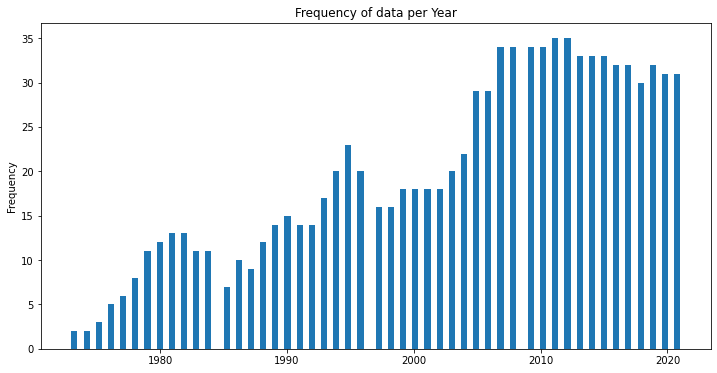

In [35]:
# https://www.ndbc.noaa.gov/data/historical/stdmet/
stmed_data_index_html = open("references/stdmet_data_index.html").read()
buoy_locations_info_df = pd.read_csv("data/02_interim/buoy_locations.csv")

data_index_df = noaa_metadata.get_buoy_stdmet_index_df(stmed_data_index_html)
metadata_df = noaa_metadata.make_ndbc_metadata_df(buoy_locations_info_df, data_index_df)
# metadata_df = metadata_df[metadata_df.year>=2011]
print("Number of individual buoy stations:", metadata_df.buoy_id.nunique())
print("Number of files available for the corresponding stations:",len(metadata_df.filename.unique()))
print("Average available buoys at a time:",metadata_df.groupby("year").buoy_id.nunique().mean().round())
display(metadata_df.head())
metadata_df.year.plot(kind="hist",title="Frequency of data per Year",bins=100, figsize=(12,6));

In [ ]:
# Write the filenames to a txt file to later wget them
url_template = "https://www.ndbc.noaa.gov/data/historical/stdmet/{filename}"
data_urls = [url_template.format(filename=f) for f in metadata_df.filename.unique()]
with open("../references/ndbc_stdmet_buoy_data_urls.txt","w") as f:
    f.write("\n".join(data_urls))

---------

### Data Description

| Field | Description |
| --- | --- |
| YY | Year |
| MM | Month |
| DD | Day |
| hh | Hour |
| mm | Minute |
| WDIR | Wind direction (the direction the wind is coming from in degrees clockwise from true N) |
| WSPD | Wind speed, averaged over an eight-minute period (m/s) |
| GST | Peak 5 or 8 second gust speed measured during the eight-minute or two-minute period(m/s) |
| WVHT | Significant wave height (meters) |
| DPD | Dominant wave period (seconds) |
| APD | Average wave period (seconds) |
| MWD | The direction from which the waves at the dominant period (DPD) are coming. The units are degrees from true North, increasing clockwise, with North as 0 (zero) degrees and East as 90 degrees. |
| PRES | Sea level pressure (hPa) |
| ATMP | Air temperature (Celsius) |
| WTMP | Sea surface temperature (Celsius) |
| DEWP | Dewpoint temperature (Celsius) |
| VIS | visibility (nautical miles) |
| TIDE | Water level in feet above or below Mean Lower Low Water, MLLW (feet) |
    
Source: https://mgimond.github.io/ES218/Week02d.html

In [2]:
from spatial_interpolation.pipelines.noaa import data_processing as dp
from spatial_interpolation.pipelines.noaa.utils.datasets import RawBuoyDataSet

import logging
logging.basicConfig()
raw_files = glob.glob("data/01_raw/ndbc_stdmet_buoy_data/*.txt.gz")[-2:-1]
raw_df = RawBuoyDataSet(raw_files[0]).load()
processed_df = dp.process_raw_stdmet_df(raw_df.drop(columns=["VIS","GST","TIDE","APD","PRES"]))
# parsed_dfs = dp.parse_raw_buoy_files(raw_files, num_cores=3)
# parsed_dfs[0]
# WDIR WSPD WVHT DPD MWD ATMP WTMP DEWP
processed_df.columns = processed_df.columns\
    .str.replace("temperature","temp")\
    .str.replace("direction","dir")\
    .str.replace("dominant_","")
display(
    processed_df.head()
    .round(1)
    .head()
    # .loc[:,["YY", "MM", "DD", "hh", "mm", "WDIR", "WSPD", "WVHT", "DPD", "MWD", "ATMP"]]
    .loc[:,["time","buoy_id","wind_dir","wind_speed","wave_height","wave_period"]]
    # .to_latex(index=False)
)
# print(
#     raw_df

# )


,time,buoy_id,wind_dir,wind_speed,wave_height,wave_period
0,2016-12-31 23:50:00,41008,50.0,3.7,0.3,10.0
1,2017-01-01 00:50:00,41008,67.0,2.5,0.3,9.1
2,2017-01-01 01:50:00,41008,55.0,2.6,0.3,10.8
3,2017-01-01 02:50:00,41008,30.0,1.9,0.4,11.4
4,2017-01-01 03:50:00,41008,103.0,2.8,0.4,10.0


----

## Analysis of data

In [2]:
import gstools as gs
import pandas as pd
from pandas import IndexSlice as idx
from spatial_interpolation import data
from subplotted import subplotted
import matplotlib.pyplot as plt
import seaborn as sns

from experiments.configs.evaluation import eval_sets
from subplotted import subplotted

%matplotlib inline

In [3]:
# get the data
ndbc_data = data.NDBCDataLoader().load()#start="2011-01-01", end="2022-01-01").load()
df, ndbc_gdf = ndbc_data.buoys_data, ndbc_data.buoys_geo
df_countries = data.load_world_borders()
ndbc_data_7d = ndbc_data.join(resample="7D").dropna(subset=["geometry"])
ndbc_data_daily = ndbc_data.join(resample="D").dropna(subset=["geometry"])

In [ ]:
station_ids = ["42019"]
times =dict(start="2020-05-05 01:00", end="2020-05-30 23:00")
partial_df = (
    df
    .loc[idx[station_ids,times["start"]:times["end"]],:]
    .dropna(subset=["wave_height","wind_speed"])
    .sort_index(level="time")
)
display(partial_df.head())
print(partial_df.index.get_level_values("time").nunique(),"timestamps")
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.lineplot(x="time", y="wave_height",data=partial_df[["wave_height"]].reset_index(), hue="buoy_id",ax=ax)
sns.scatterplot(x="time", y="wave_height",data=partial_df[["wave_height"]].reset_index(), color="black", ax=ax)
plt.show()
# count of stations with data
print("count of values by station:")
display(partial_df.index.get_level_values("buoy_id").value_counts())
# overlap times?
print("Overlaps:")
counts_df = partial_df.groupby("time").count().wave_height
counts_df.plot()
plt.show()
display(counts_df.sort_values().tail(5))
for i in range(0,len(station_ids)):
    partial_overlapped = partial_df.loc[idx[:,counts_df.gt(i).pipe(lambda x: x[x]).index],:]
    unique_ids = {a for a in partial_overlapped.index.get_level_values('buoy_id').unique()}
    print(f"overlaps of {i+1} stations: {sum(counts_df.gt(i))} ({unique_ids}). Missing: {set(station_ids) - unique_ids}")
print(sum(counts_df.gt(len(station_ids)-1)), "full overlaps")
print("Most overlaps")
display(
    partial_df.loc[idx[:,counts_df.sort_values().index[:5],:]]
)

In [ ]:
variable = "wave_height"
time = counts_df.idxmax()
#pd.Timestamp(times["start"]) + (pd.Timestamp(times["end"])-pd.Timestamp(times["start"]))/2
#buoy_df.index.get_level_values("time").max()
map_viz.add_geodf_to_map(
    df.loc[idx[:,time],:]
        .join(ndbc_gdf.loc[pd.Timestamp(time).year])
        .dropna(subset=["wave_height","wind_speed"]),
    radius=1,
    weight=5,
    map_args={"zoom_start":4.5},
    popup=lambda x: f"{x.buoy_name} {x.name}",
    color = lambda x: "red" if x.name[0] in station_ids else "blue")

In [ ]:
map_viz.heatmap_with_time(ndbc_data_7d.loc[idx[:,times["start"]:times["end"]],:].sort_index(level="time"), "time", zoom_start=4)

In [ ]:
import folium
from functools import partial
buoy_ids = ndbc_gdf.index.get_level_values("buoy_id").unique()
buoy_locations_info_df = buoy_locations_info_df[(buoy_locations_info_df.year>=2011)&(buoy_locations_info_df.buoy_id.isin(buoy_ids))]
map_viz.make_map_of_buoys(
    location = (26.382792, -82.192264),
    buoy_locations_df=buoy_locations_info_df[buoy_locations_info_df.year>=2011], 
    marker=partial(folium.CircleMarker, radius=1, weight=5,color="black"),
)

In [ ]:
## visualize each ara (A, B, C)
# transform data
ndbc_geo = ndbc_gdf.loc[2000:2022].groupby("buoy_id").first()
ndbc_data_daily = ndbc_data_daily.dropna(subset=["wave_height"])
available_buoys = ndbc_data_daily.groupby("buoy_id").size()[ndbc_data_daily.groupby("buoy_id").size()>35].index
ndbc_geo = ndbc_geo[ndbc_geo.index.isin(available_buoys)]

# fig, axes = plt.subplots(len(eval_sets.ndbc), 1, figsize=(12,16))
for S, ax, (i, set_conf) in subplotted(enumerate(eval_sets.ndbc.values()), ncols=1, figsize=(12,16), facecolor="white"):
    partial_buoys = {loc for partial_conf in set_conf.partial.values() for loc in partial_conf.locations}
    full_buoys = set_conf.locations_full
    set_geo =  ndbc_geo.loc[ndbc_geo.within(set_conf.area)]
    set_letter = chr(ord("A")+i)
    xmin, ymin, xmax, ymax = set_conf.area.bounds
    df_countries.plot(ax=ax, alpha=0.5)
    ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
    set_geo.plot(ax=ax, color="blue")
    # red points represent buoys in the eval set
    set_geo[(set_geo.index.isin(partial_buoys))].plot(ax=ax, color="red", alpha=0.5)
    set_geo[(set_geo.index.isin(full_buoys))].plot(ax=ax, color="red")
    # those surrounded by a circle represent buoys that are fully in the eval set (not partial)
    set_geo[set_geo.index.isin(full_buoys)].plot(ax=ax, marker="o", markersize=500, facecolor="none", edgecolor="red")
    ax.set_ylabel(f"Area {i+1}", rotation=0, fontsize=12, labelpad=25)
    ax.set_xticks([]); ax.set_yticks([])
else:
    S.fig.suptitle("Map of available buoy locations in each set of the NDBC Data", fontsize=16)
    S.fig.tight_layout();
    # accomodate to give margin for the title
    S.fig.subplots_adjust(top=0.95);
    S.fig.savefig("reports/figures/available_buoys_per_set.png", dpi=300, bbox_inches="tight")
S.fig.show()


In [ ]:
for S, ax, (i,set_conf) in subplotted(enumerate(eval_sets.ndbc.values()), ncols=3, figsize=(18,8), facecolor="white", sharey=True):
    set_geo =  ndbc_gdf.loc[ndbc_gdf.within(set_conf.area)]
    set_geo.index\
        .get_level_values("year")\
        .to_series()\
        .plot(ax=ax, kind="hist",title=f"Area {i+1}", bins=90)
    ax.set_ylim(0,60)
    ax.set_title(f"Area {i+1}", fontsize=14)
else:
    # S.fig.suptitle("Frequency of data per year in each set of the NDBC Data", fontsize=16)
    S.fig.tight_layout()
    # S.fig.subplots_adjust(top=0.92)
    # S.set_all(ylabel="", yticklabels=[], indices=[1,2])
    S.fig.savefig("reports/figures/ndbc_buoy_sets_year.png", dpi=300, bbox_inches="tight")

-------

### Analysis of Variables

### Histograms and Distributions

<AxesSubplot:xlabel='time'>

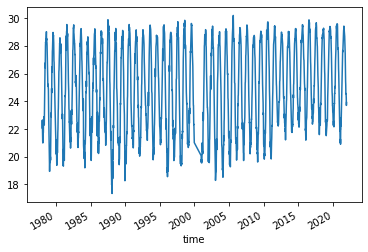

In [123]:
ndbc_data_7d.groupby("time").mean()["water_temperature"].plot()

In [ ]:
# histogram of the data
# with subplotted(df.columns, ncols=1, figsize=(8,4*len(df.columns)), facecolor="white") as S:
#    for ax, col in S:
#        df[col].plot(kind="hist", bins=100)
cols = [col for col in df.columns if ndbc_data_7d[col].count()/len(ndbc_data_7d) > 0.4]
# cols = ["wave_height", "air_temperature", "wind_direction", "wind_speed","water_temperature","mean_wave_direction"]
# fig, axes = plt.subplots(nrows=len(cols)//3,ncols=3, figsize=(8,12), facecolor="white")[0]
c, skipped = 0, 0
for S, ax, col in subplotted(cols, ncols=3, figsize=(12,4*len(cols)//3)):
    if int(ndbc_data_7d[col].max()) in [999,9999]:
        ndbc_data_7d[col] = ndbc_data_7d[col].replace(ndbc_data_7d[col].max(), np.nan)
    ndbc_data_7d[col].plot(ax=ax, kind="hist", bins=90)
    ax.set_ylabel(None)#, rotation=0, fontsize=12, labelpad=25)
    ax.set_title(col)
else:
    S.fig.tight_layout()
    S.fig.savefig(f"reports/figures/ndbc_histograms.png", dpi=300, bbox_inches="tight")

---

In [ ]:
import seaborn as sns
# plot correlation matrix
fig, ax = plt.subplots(figsize=(14,12), facecolor="w")
ax = sns.heatmap(
    df
    .loc[:,cols]
    .groupby("time")
    .mean()
    .dropna(how="all",axis=1)
    .dropna(subset=["wave_height"])
    .sort_index()
    .corr("pearson"),
    cmap="RdBu_r",
    ax=ax,
    vmin=-1,
    vmax=1,
)
ax.set_title("Correlation Matrix of the NDBC Buoy Data")
fig.tight_layout()
fig.savefig("reports/figures/ndbc_corr_matrix.png", dpi=300)